In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# 1. Make Data X_train, y_train, X_test, y_test

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [6]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

inp = open(file_path+'detect_peptide_train_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 177997 peptides and skipped 0
Loading input peptides
Succesfully loaded 44499 peptides and skipped 0
(142397, 30) (35600, 30) (44499, 30) (142397,) (35600,) (44499,)


# 2. train

In [8]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
__________________

In [10]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 142397 samples, validate on 35600 samples
Epoch 1/200
142397/142397 [==============================] - 14s 102us/sample - loss: 0.6247 - acc: 0.7126 - val_loss: 0.5957 - val_acc: 0.7982
Epoch 2/200
142397/142397 [==============================] - 14s 97us/sample - loss: 0.5942 - acc: 0.8012 - val_loss: 0.5924 - val_acc: 0.8100
Epoch 3/200
142397/142397 [==============================] - 14s 98us/sample - loss: 0.5922 - acc: 0.8056 - val_loss: 0.5905 - val_acc: 0.8115
Epoch 4/200
142397/142397 [==============================] - 14s 97us/sample - loss: 0.5909 - acc: 0.8090 - val_loss: 0.5896 - val_acc: 0.8145
Epoch 5/200
142397/142397 [==============================] - 14s 97us/sample - loss: 0.5894 - acc: 0.8139 - val_loss: 0.5875 - val_acc: 0.8212
Epoch 6/200
142397/142397 [==============================] - 14s 96us/sample - loss: 0.5880 - acc: 0.8180 - val_loss: 0.5858 - val_acc: 0.8266
Epoch 7/200
142397/142397 [==============================] - 14s 97us/sample - loss: 0.586

142397/142397 [==============================] - 25s 173us/sample - loss: 0.5749 - acc: 0.8454 - val_loss: 0.5767 - val_acc: 0.8462
Epoch 58/200
142397/142397 [==============================] - 25s 173us/sample - loss: 0.5748 - acc: 0.8452 - val_loss: 0.5774 - val_acc: 0.8376
Epoch 59/200
142397/142397 [==============================] - 25s 174us/sample - loss: 0.5744 - acc: 0.8467 - val_loss: 0.5785 - val_acc: 0.8364
Epoch 60/200
142397/142397 [==============================] - 25s 176us/sample - loss: 0.5746 - acc: 0.8457 - val_loss: 0.5775 - val_acc: 0.8478
Epoch 61/200
142397/142397 [==============================] - 25s 176us/sample - loss: 0.5745 - acc: 0.8466 - val_loss: 0.5766 - val_acc: 0.8417
Epoch 62/200
142397/142397 [==============================] - 25s 178us/sample - loss: 0.5745 - acc: 0.8460 - val_loss: 0.5763 - val_acc: 0.8447
Epoch 63/200
142397/142397 [==============================] - 24s 172us/sample - loss: 0.5741 - acc: 0.8474 - val_loss: 0.5774 - val_acc: 0.844

142397/142397 [==============================] - 25s 175us/sample - loss: 0.5696 - acc: 0.8565 - val_loss: 0.5735 - val_acc: 0.8515
Epoch 114/200
142397/142397 [==============================] - 25s 175us/sample - loss: 0.5698 - acc: 0.8561 - val_loss: 0.5732 - val_acc: 0.8515
Epoch 115/200
142397/142397 [==============================] - 25s 177us/sample - loss: 0.5699 - acc: 0.8559 - val_loss: 0.5727 - val_acc: 0.8526
Epoch 116/200
142397/142397 [==============================] - 25s 176us/sample - loss: 0.5701 - acc: 0.8554 - val_loss: 0.5729 - val_acc: 0.8546
Epoch 117/200
142397/142397 [==============================] - 26s 183us/sample - loss: 0.5698 - acc: 0.8558 - val_loss: 0.5727 - val_acc: 0.8524
Epoch 118/200
142397/142397 [==============================] - 25s 177us/sample - loss: 0.5697 - acc: 0.8565 - val_loss: 0.5729 - val_acc: 0.8518
Epoch 119/200
142397/142397 [==============================] - 25s 173us/sample - loss: 0.5695 - acc: 0.8565 - val_loss: 0.5729 - val_acc:

142397/142397 [==============================] - 25s 175us/sample - loss: 0.5679 - acc: 0.8600 - val_loss: 0.5716 - val_acc: 0.8560
Epoch 170/200
142397/142397 [==============================] - 25s 176us/sample - loss: 0.5679 - acc: 0.8599 - val_loss: 0.5730 - val_acc: 0.8530
Epoch 171/200
142397/142397 [==============================] - 26s 180us/sample - loss: 0.5677 - acc: 0.8606 - val_loss: 0.5739 - val_acc: 0.8438
Epoch 172/200
142397/142397 [==============================] - 25s 174us/sample - loss: 0.5676 - acc: 0.8609 - val_loss: 0.5719 - val_acc: 0.8526
Epoch 173/200
142397/142397 [==============================] - 25s 177us/sample - loss: 0.5677 - acc: 0.8603 - val_loss: 0.5723 - val_acc: 0.8553
Epoch 174/200
142397/142397 [==============================] - 25s 175us/sample - loss: 0.5675 - acc: 0.8607 - val_loss: 0.5720 - val_acc: 0.8550
Epoch 175/200
142397/142397 [==============================] - 25s 176us/sample - loss: 0.5675 - acc: 0.8608 - val_loss: 0.5723 - val_acc:

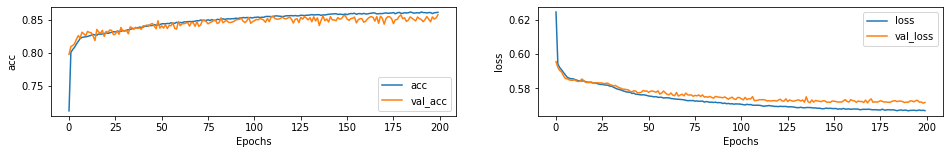

In [11]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 2-2. Github code

Loading input peptides
Succesfully loaded 177997 peptides and skipped 0
Loading input peptides
Succesfully loaded 44499 peptides and skipped 0
(142397, 81) (35600, 81) (44499, 81) (142397,) (35600,) (44499,)
Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 142397 samples, validate on 35600 samples
Epoch 1/200
142397/142397 [==============================] - 33s 230us/sample - loss: 0.4559 - acc: 0.7828 - binary_crossentropy: 0.4559 - val_loss: 0.3683 - val_acc: 0.8390 - val_binary_crossentropy: 0.3683
Epoch 2/200
142397/142397 [==============================] - 32s 224us/sample - loss: 0.3736 - acc: 0.8373 - binary_crossentropy: 0.3736 - val_loss: 0.3563 - val_acc: 0.8428 - val_binary_crossentropy: 0.3563
Epoch 3/200
142397/142397 [==============================] - 32s 223us/s

Epoch 35/200
142397/142397 [==============================] - 32s 223us/sample - loss: 0.3000 - acc: 0.8711 - binary_crossentropy: 0.3000 - val_loss: 0.3232 - val_acc: 0.8614 - val_binary_crossentropy: 0.3232
Epoch 36/200
142397/142397 [==============================] - 31s 219us/sample - loss: 0.2977 - acc: 0.8721 - binary_crossentropy: 0.2977 - val_loss: 0.3258 - val_acc: 0.8619 - val_binary_crossentropy: 0.3258
Epoch 37/200
142397/142397 [==============================] - 31s 217us/sample - loss: 0.2981 - acc: 0.8718 - binary_crossentropy: 0.2981 - val_loss: 0.3217 - val_acc: 0.8609 - val_binary_crossentropy: 0.3217
Epoch 38/200
142397/142397 [==============================] - 31s 217us/sample - loss: 0.2970 - acc: 0.8723 - binary_crossentropy: 0.2970 - val_loss: 0.3230 - val_acc: 0.8617 - val_binary_crossentropy: 0.3230
Epoch 39/200
142397/142397 [==============================] - 32s 224us/sample - loss: 0.2961 - acc: 0.8734 - binary_crossentropy: 0.2961 - val_loss: 0.3238 - val_a

142397/142397 [==============================] - 32s 223us/sample - loss: 0.2816 - acc: 0.8795 - binary_crossentropy: 0.2816 - val_loss: 0.3283 - val_acc: 0.8609 - val_binary_crossentropy: 0.3283
Epoch 75/200
142397/142397 [==============================] - 32s 223us/sample - loss: 0.2813 - acc: 0.8797 - binary_crossentropy: 0.2813 - val_loss: 0.3273 - val_acc: 0.8590 - val_binary_crossentropy: 0.3273
Epoch 76/200
142397/142397 [==============================] - 32s 222us/sample - loss: 0.2809 - acc: 0.8799 - binary_crossentropy: 0.2809 - val_loss: 0.3309 - val_acc: 0.8597 - val_binary_crossentropy: 0.3309
Epoch 77/200
142397/142397 [==============================] - 32s 225us/sample - loss: 0.2814 - acc: 0.8793 - binary_crossentropy: 0.2814 - val_loss: 0.3235 - val_acc: 0.8611 - val_binary_crossentropy: 0.3235
Epoch 78/200
142397/142397 [==============================] - 32s 222us/sample - loss: 0.2800 - acc: 0.8798 - binary_crossentropy: 0.2800 - val_loss: 0.3278 - val_acc: 0.8587 - 

142397/142397 [==============================] - 32s 223us/sample - loss: 0.2724 - acc: 0.8842 - binary_crossentropy: 0.2724 - val_loss: 0.3291 - val_acc: 0.8591 - val_binary_crossentropy: 0.3291
Epoch 114/200
142397/142397 [==============================] - 32s 226us/sample - loss: 0.2723 - acc: 0.8836 - binary_crossentropy: 0.2723 - val_loss: 0.3296 - val_acc: 0.8592 - val_binary_crossentropy: 0.3296
Epoch 115/200
142397/142397 [==============================] - 32s 222us/sample - loss: 0.2720 - acc: 0.8840 - binary_crossentropy: 0.2720 - val_loss: 0.3270 - val_acc: 0.8601 - val_binary_crossentropy: 0.3270
Epoch 116/200
142397/142397 [==============================] - 32s 225us/sample - loss: 0.2721 - acc: 0.8839 - binary_crossentropy: 0.2721 - val_loss: 0.3286 - val_acc: 0.8610 - val_binary_crossentropy: 0.3286
Epoch 117/200
142397/142397 [==============================] - 32s 223us/sample - loss: 0.2717 - acc: 0.8835 - binary_crossentropy: 0.2717 - val_loss: 0.3343 - val_acc: 0.860

142397/142397 [==============================] - 32s 222us/sample - loss: 0.2672 - acc: 0.8865 - binary_crossentropy: 0.2672 - val_loss: 0.3455 - val_acc: 0.8578 - val_binary_crossentropy: 0.3455
Epoch 153/200
142397/142397 [==============================] - 32s 223us/sample - loss: 0.2654 - acc: 0.8871 - binary_crossentropy: 0.2654 - val_loss: 0.3322 - val_acc: 0.8572 - val_binary_crossentropy: 0.3322
Epoch 154/200
142397/142397 [==============================] - 32s 224us/sample - loss: 0.2653 - acc: 0.8869 - binary_crossentropy: 0.2653 - val_loss: 0.3341 - val_acc: 0.8542 - val_binary_crossentropy: 0.3341
Epoch 155/200
142397/142397 [==============================] - 32s 225us/sample - loss: 0.2655 - acc: 0.8868 - binary_crossentropy: 0.2655 - val_loss: 0.3418 - val_acc: 0.8584 - val_binary_crossentropy: 0.3418
Epoch 156/200
142397/142397 [==============================] - 32s 224us/sample - loss: 0.2656 - acc: 0.8870 - binary_crossentropy: 0.2656 - val_loss: 0.3364 - val_acc: 0.858

142397/142397 [==============================] - 32s 224us/sample - loss: 0.2616 - acc: 0.8882 - binary_crossentropy: 0.2616 - val_loss: 0.3349 - val_acc: 0.8596 - val_binary_crossentropy: 0.3349
Epoch 192/200
142397/142397 [==============================] - 32s 226us/sample - loss: 0.2609 - acc: 0.8884 - binary_crossentropy: 0.2609 - val_loss: 0.3491 - val_acc: 0.8582 - val_binary_crossentropy: 0.3491
Epoch 193/200
142397/142397 [==============================] - 32s 224us/sample - loss: 0.2622 - acc: 0.8887 - binary_crossentropy: 0.2622 - val_loss: 0.3471 - val_acc: 0.8564 - val_binary_crossentropy: 0.3471
Epoch 194/200
142397/142397 [==============================] - 32s 226us/sample - loss: 0.2619 - acc: 0.8884 - binary_crossentropy: 0.2619 - val_loss: 0.3388 - val_acc: 0.8576 - val_binary_crossentropy: 0.3388
Epoch 195/200
142397/142397 [==============================] - 32s 223us/sample - loss: 0.2614 - acc: 0.8883 - binary_crossentropy: 0.2614 - val_loss: 0.3370 - val_acc: 0.858

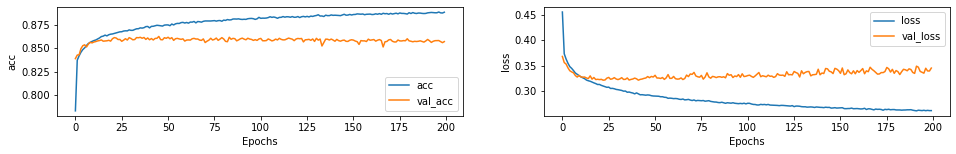

In [12]:
args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm.txt')
y_train81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm.txt')
y_test81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train81, X_val81, y_train81, y_val81 = train_test_split(X_train81, y_train81, test_size=0.2)
print(X_train81.shape, X_val81.shape, X_test81.shape, y_train81.shape, y_val81.shape, y_test81.shape)


print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')

history_github = model_2_1D.fit(X_train81, y_train81, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val81, y_val81))

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_github, 'acc')
plt.subplot(1,2,2)
plot_graphs(history_github, 'loss')

# 3. test

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

44499/44499 [==============================] - 4s 98us/sample - loss: 0.5720 - acc: 0.8579
Test Loss: 0.5719843437643318
Test Accuracy: 0.8579069375991821
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     22330
           1       0.87      0.84      0.85     22169

    accuracy                           0.86     44499
   macro avg       0.86      0.86      0.86     44499
weighted avg       0.86      0.86      0.86     44499

rf auc : 0.9198433381625664


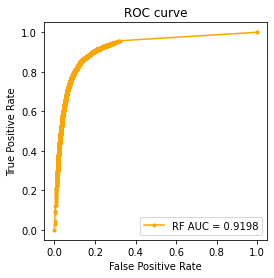

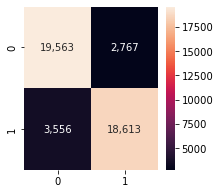

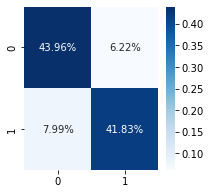

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

44499/44499 [==============================] - 5s 121us/sample - loss: 0.3499 - acc: 0.8548 - binary_crossentropy: 0.3499
Test Loss: 0.5719843437643318
Test Accuracy: [0.3499321629622456, 0.85478324, 0.34993193]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     22330
           1       0.83      0.90      0.86     22169

    accuracy                           0.85     44499
   macro avg       0.86      0.85      0.85     44499
weighted avg       0.86      0.85      0.85     44499

rf auc : 0.9310291316085365


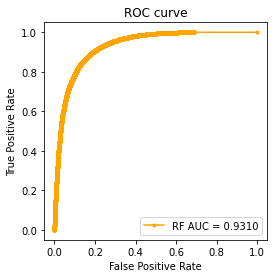

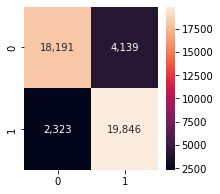

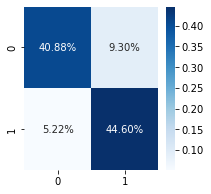

In [15]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()